In [1]:
import collections
import seaborn as sns
import os
import glob
import numpy as np
from sklearn.decomposition import PCA
import re
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE
from wordcloud import WordCloud

Автоматический поиск произведений в папках texts/txt/\*\* (вместо \*\* — имя автора) и создание словарей *название-путь\_к\_файлу* (TITLE_PATH_DICT), *название-автор* (TITLE_AUTHOR_DICT), *автор-множество\_названий\_произведений* (AUTHOR__TITLE_SET__DICT).

In [2]:
FILE_PATHS = glob.glob('texts/txt_4books/**/*.txt', recursive=True)

In [3]:
TITLE_PATH_DICT = {path.split("\\")[-1].split(".")[0] : path for path in FILE_PATHS}
TITLE_AUTHOR_DICT = {path.split("\\")[-1].split(".")[0] : path.split("\\")[-2] for path in FILE_PATHS}

In [4]:
AUTHOR__TITLE_SET__DICT = collections.defaultdict(set)
for title, author in TITLE_AUTHOR_DICT.items():
    AUTHOR__TITLE_SET__DICT[author].add(title)
AUTHOR__TITLE_SET__DICT = dict(AUTHOR__TITLE_SET__DICT)

In [5]:
NPY_FOLDER = 'texts/500_sentences/'

### Подсчет числа различных знаков препинания 

In [6]:
def get_punctuation_from_text(text, punctuation_marks=None):
    if punctuation_marks is None:
        punctuation_marks = ".?!…,:;—()\"'-"
    text = text.lower()
    text = text.replace("...", "…").replace("–", "—").replace("«", '"').replace("»", '"')
    punct_str = re.sub(r'[^' + punctuation_marks + ']+', '', text)
    punct_list = [char for char in punct_str]
    return punct_list

In [27]:
punctuation_marks = ",:;\".?!…('—-"

In [48]:
def make_punct_count_df(excerpt_mul=1):
    columns=['author'] + [punct for punct in punctuation_marks]

    df_npy_punct_count = pd.DataFrame(columns=columns)

    num_of_npys = len(glob.glob(f'{NPY_FOLDER}/**/*.npy', recursive=True))
    with tqdm(total=num_of_npys) as pbar:
        for author in AUTHOR__TITLE_SET__DICT.keys():
            npy_paths = glob.glob(f'{NPY_FOLDER}/{author}/*.npy', recursive=True)
            for i in range(0, len(npy_paths), excerpt_mul):
                book_punct_counter = collections.defaultdict(int)
                marks = []
                for npy_path in npy_paths[i:i+excerpt_mul]:
                    marks = np.concatenate([
                        marks,
                        get_punctuation_from_text(' '.join(np.load(npy_path)), punctuation_marks)
                    ])
                for mark in marks:
                    book_punct_counter[mark] += 1
                tmp_df = pd.DataFrame(
                    [[author] + [book_punct_counter[mark] / len(marks) for mark in punctuation_marks]], 
                    columns=columns
                )
                df_npy_punct_count = pd.concat([df_npy_punct_count, tmp_df], ignore_index=True)
                pbar.update(excerpt_mul)
    return df_npy_punct_count

def punct_count_tsne(excerpt_mul=1, info=""):
    df_npy_punct_count = make_punct_count_df(excerpt_mul)
    
    df_npy_punct_count_no_author = df_npy_punct_count.copy()
    df_author_only = df_npy_punct_count_no_author.pop("author")
    
    tsne = TSNE(n_components=2, learning_rate=100, random_state=273)
    tsne_results = tsne.fit_transform(df_npy_punct_count_no_author)

    df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
    df_tsne["label"] = df_author_only
    
    sns.lmplot(x="comp1", y="comp2", data=df_tsne, hue="label", fit_reg=False)
    plt.title(f"{info}\nt-SNE по долям различных знаков препинания." + 
              f"\nДлина отрывков {500*excerpt_mul} предложений.")
    plt.show()

In [49]:
make_punct_count_df(1).head()

100%|███████████████████████████████████████████████████████████████████████████████| 854/854 [00:05<00:00, 157.18it/s]


,author,",",:,;,"""",.,?,!,…,(,',—,-
0,anton-chekhov,0.520021,0.020281,0.026521,0.020801,0.169007,0.022881,0.044202,0.027561,0.000520,0.000000,0.107124,0.041082
1,anton-chekhov,0.435472,0.016604,0.009811,0.022642,0.181887,0.024906,0.108679,0.073208,0.001509,0.000000,0.090566,0.034717
2,anton-chekhov,0.529736,0.008811,0.023128,0.008811,0.194383,0.016520,0.049559,0.017621,0.000551,0.000000,0.118943,0.031938
3,anton-chekhov,0.395786,0.017306,0.002257,0.018059,0.207675,0.020316,0.080512,0.073740,0.000752,0.000000,0.154251,0.029345
4,anton-chekhov,0.503364,0.011621,0.005505,0.025688,0.173089,0.028746,0.042813,0.061774,0.001223,0.001223,0.110703,0.034251


100%|███████████████████████████████████████████████████████████████████████████████| 854/854 [00:02<00:00, 299.65it/s]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


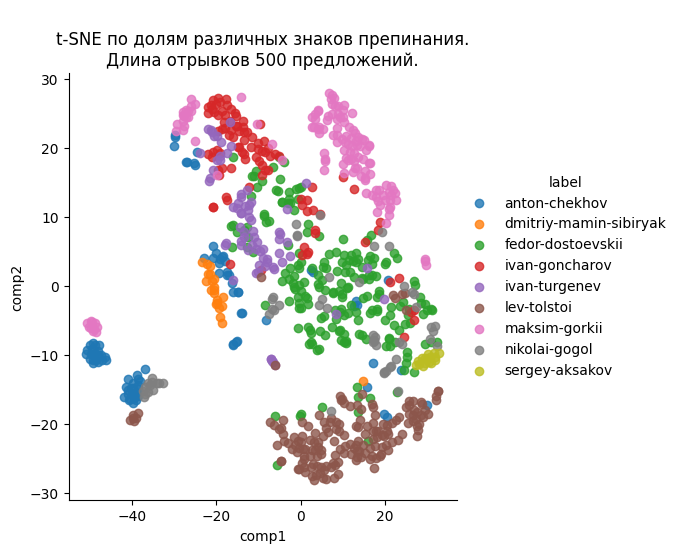

858it [00:02, 331.53it/s]                                                                                              
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


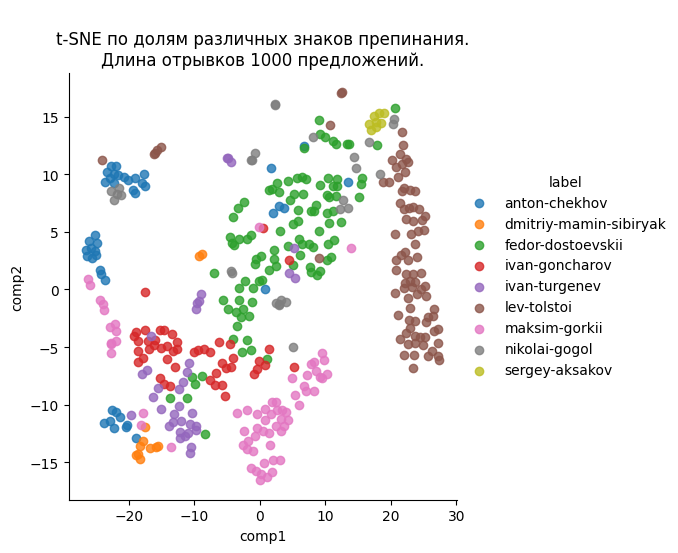

861it [00:02, 342.48it/s]                                                                                              
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


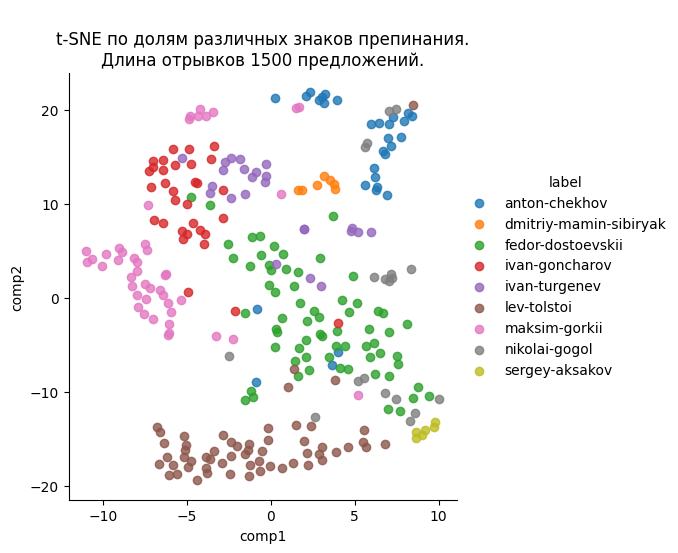

864it [00:02, 343.27it/s]                                                                                              
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


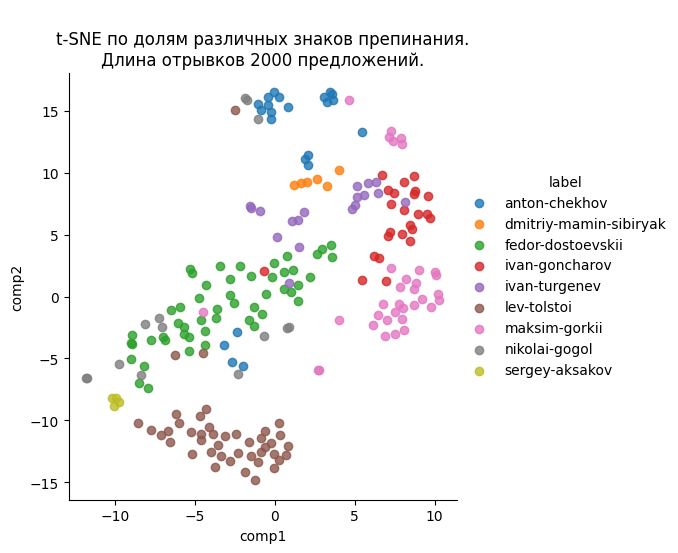

In [50]:
for i in range(1, 5):
    punct_count_tsne(i)

In [46]:
df_npy_punct_count = make_punct_count_df()

100%|███████████████████████████████████████████████████████████████████████████████| 854/854 [00:02<00:00, 303.26it/s]


In [42]:
def make_punct_frequency_boxplot(df, mark):
    boxplot = sns.boxplot(x=mark, y='author', data=df, orient = 'h')
    plt.title(f"Частота знака [ {mark} ]")
    plt.show()

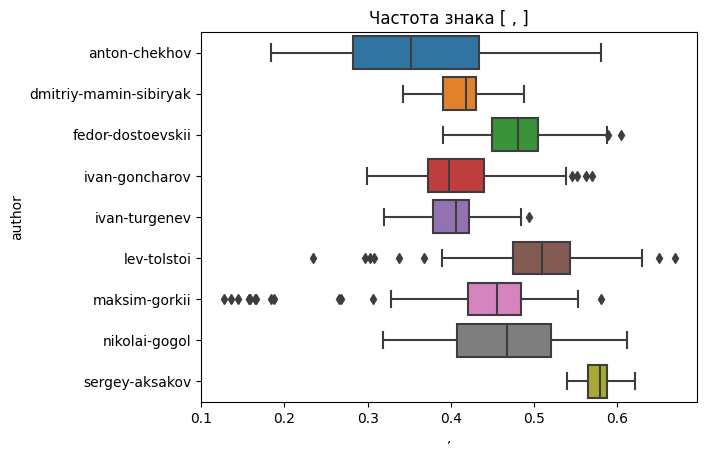

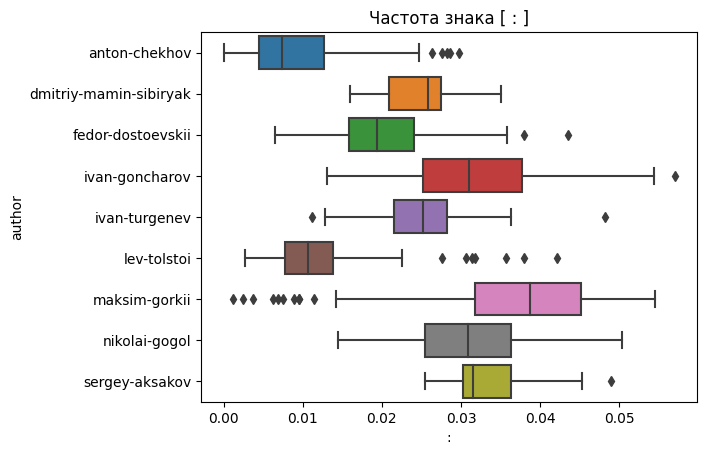

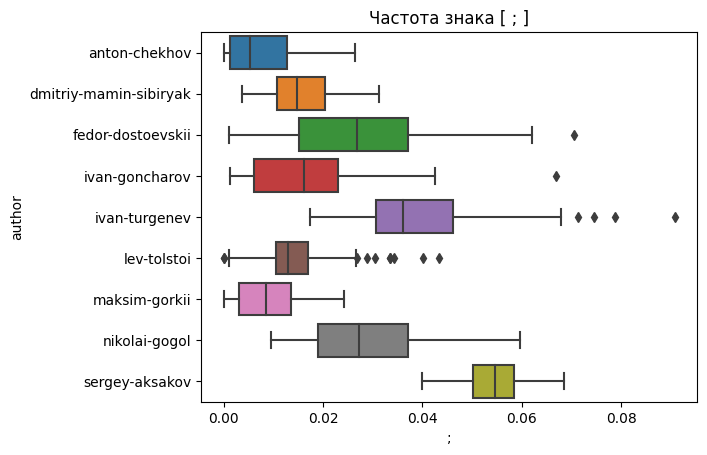

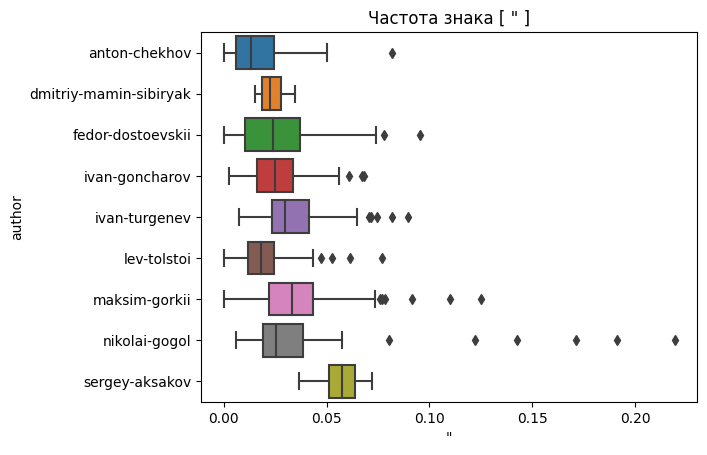

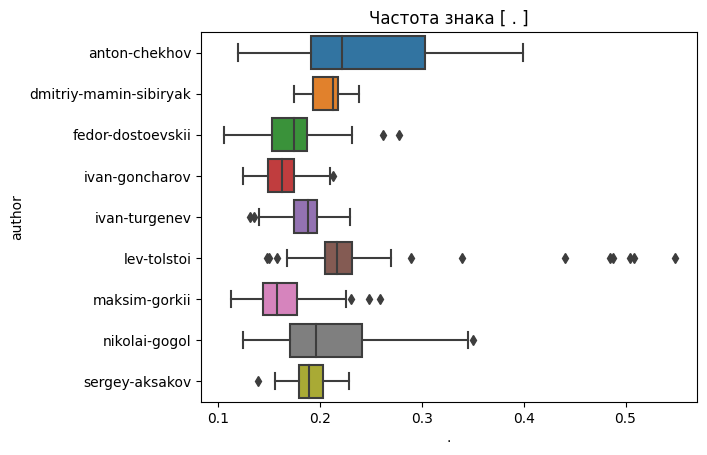

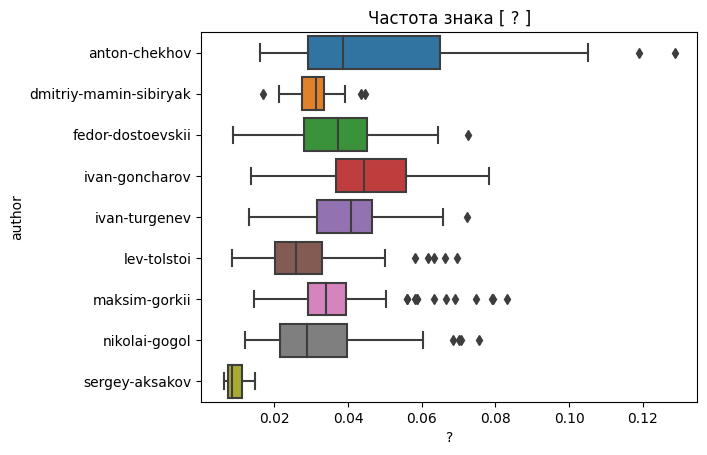

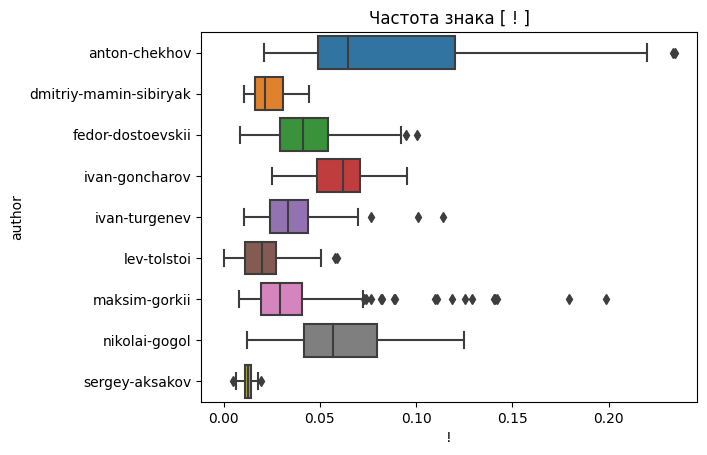

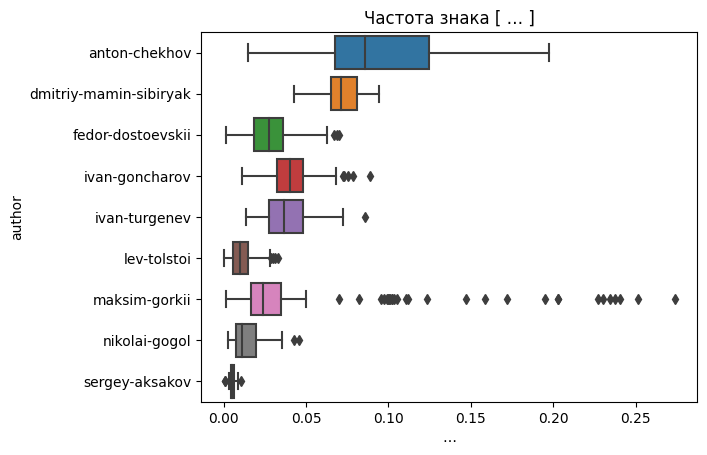

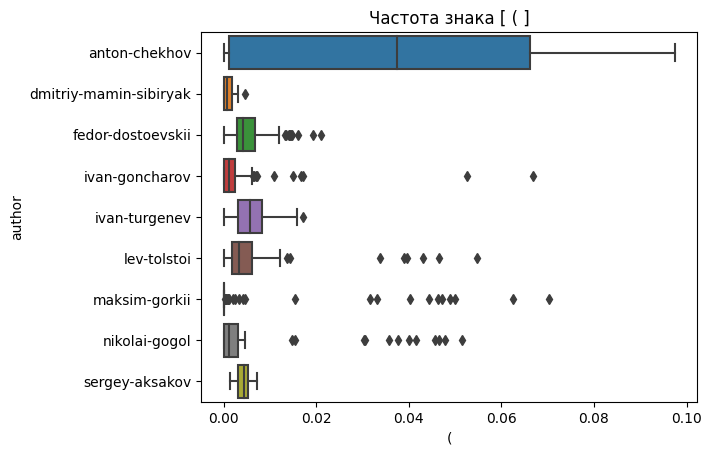

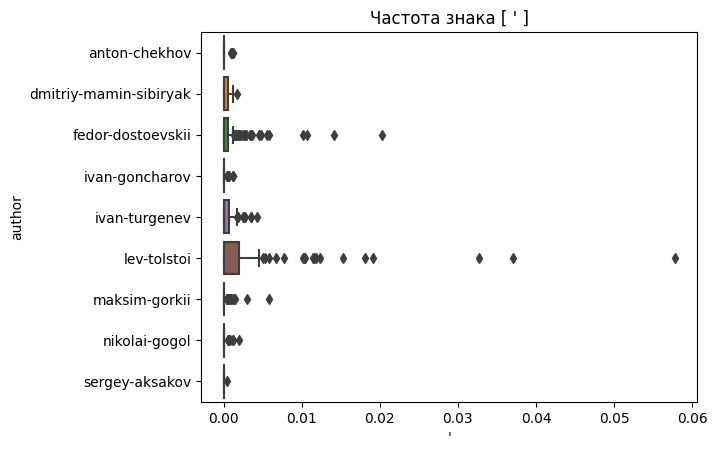

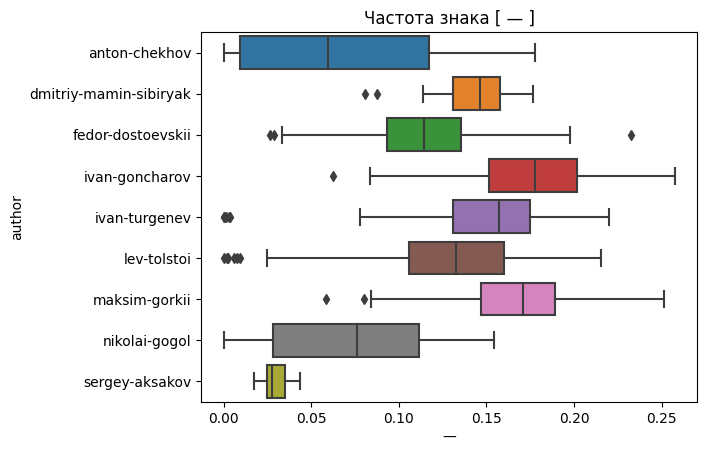

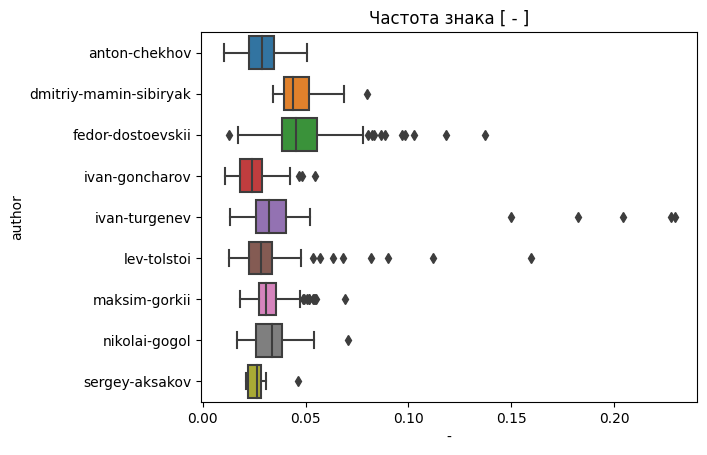

In [47]:
for mark in punctuation_marks:
    make_punct_frequency_boxplot(df_npy_punct_count, mark)

## Формирование вектора признаков по пунктуации

In [52]:
df = make_punct_count_df()

100%|███████████████████████████████████████████████████████████████████████████████| 854/854 [00:02<00:00, 298.49it/s]


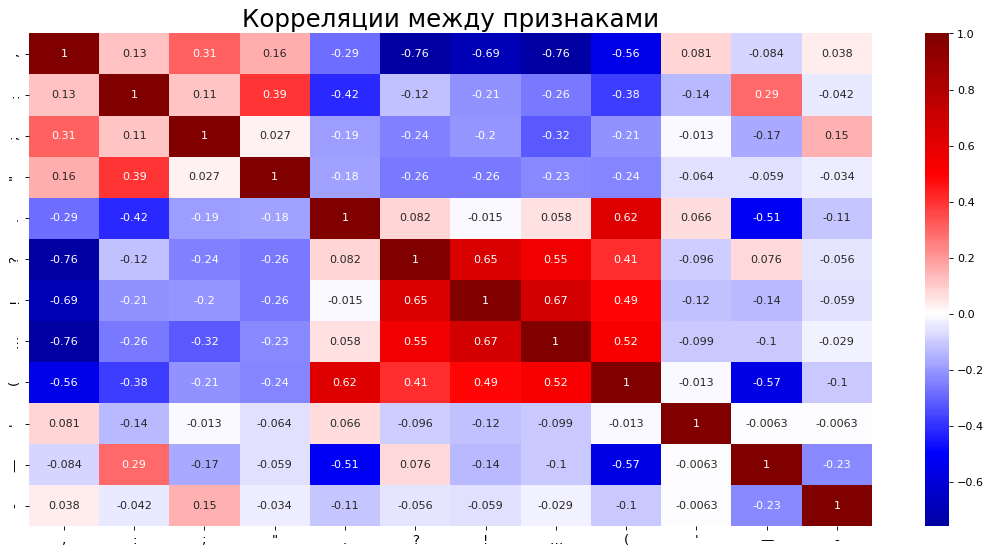

In [57]:
df_corr = df.corr(method='pearson')

plt.figure(figsize=(17,8), dpi= 80)
sns.heatmap(df_corr, 
            xticklabels=df_corr.columns, 
            yticklabels=df_corr.columns, cmap='seismic', center=0, annot=True)

plt.title('Корреляции между признаками', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()